<a id='top'></a>

#  IBM Q Apply Jupyter Notebook
Author: Christian Lenke, IBM<br>
Version: 2019-07-23

## Table of content

* [Preface](#intro)
* [Introduction](#intro)
<p>
* [Installation, import, function definition](#preparation)
  * [Environment Definition and Customization](#customization)
  * [Get a connection to the Q Apply Server](#connect_qapp)
<p>
* [Q Apply Status overview](#overview_qapp)
  * [General Q Apply overview](#overview_qapp)
  * [Receive Queue state](#recvq)
  * [Q Subscription state by Receive Queue](#qsubs_recvq)    
  * [Q Subscription type by Receive Queue](#qsubs_type)        
<p>
* [Q Apply performance graphs](#qapp_performance_hour)
  * [APPLYMON KPIs per hour](#qapp_performance_hour)    
  * [APPLYMON KPIs per day](#qapp_performance_day)        
  * [Detailed APPLYMON KPIs (one hour of data)](#qapp_performance_details)            
<p>
* [Status details](#qapp_details)
  * [Receive Queue details](#qapp_details)
  * [Q Subscription details](#qsubs_details)
  * [Q Subscription quality assurance](#qsubs_qa)        
<p>
* [Q Apply Control Tables](#qapp_cntl)
  * [APPLYPARMS](#qapp_cntl)
  * [APPLYMON](#qapp_mon)
  * [APPLYTRACE](#qapp_trace)            

[Back to Top](#top)
<a id='intro'></a>

## Preface

This Jupyter Notebook is sample code. No warranty.

## Introduction

This set of Jupyter Notebook can be used to display status, performance, and health of an IBM Q Replication setup. The following components are provided:
 <ul>
  <li>Q Capture Jupyter Notebook</li>
  <li>Q Apply Jupyter Notebook (this Notebook)</li>
  <li>Q Replication function library Jupyter Notebook</li>
  <li>A set of SQL queries in files (asnmonitor) for status calculation and quality assurance</li>    
</ul> 
The Notebooks display the content of the IBM Q Replication control tables. This includes an overall health summary for both Q Capture and Q Apply, performance graphs (throughput, latency, etc.), and control table details for both queues and subscriptions.<br>
Start with the following:<br>
 <ol>
  <li>Copy the set of SQL query files to a location in your environment</li>
  <li>Cuctomize some of the SQL files depending on your environment</li>
  <li>Customize the Q Replication function library (details explained in that Notebook)</li>
  <li>Customize the Q Capture and Q Apply Notebooks in Section "Environment Definition and Customization" 
</ol> 
To better understand the Q Replication control tables and the SQL queries used, have a look at<br>
<A HREF="https://developer.ibm.com/recipes/tutorials/q-replication-for-dbas/">Q Replication for DBAs</A>,<br>
<A HREF="https://www.ibm.com/support/knowledgecenter/en/SSTRGZ_11.4.0/com.ibm.swg.im.iis.repl.qrepl.doc/topics/iiyrqctbrcaplist.html">Control tables at the Q Capture server</A>,<br> 
<A HREF="https://www.ibm.com/support/knowledgecenter/en/SSTRGZ_11.4.0/com.ibm.swg.im.iis.repl.qrepl.doc/topics/iiyrqctbrapplist.html">Control tables at the Q Apply server</A>, or <br>
<A HREF="https://www.ibm.com/support/knowledgecenter/en/SSTRGZ_11.4.0/com.ibm.swg.im.iis.db.repl.intro.doc/topics/iiyrqinfroadmap.html">Q Replication Information Roadmap (IBM Knowledge Center)</A>

[Back to Top](#top)
<a id='preparation'></a>

# Preparation

## Installation, import, function definition 

First of all the "IBM Q Replication Monitoring Jupyter Library.ipynb" is run. It imports all required libraries (SQLAlchemy, pandas, pixiedust, ...) and defines functions used in this Notebook.

In [1]:
%run "IBM Q Replication Monitoring Jupyter Library.ipynb"

# bereits in Library importiert
# from sqlalchemy import exc

Pixiedust database opened successfully


IBM Q Replication Monitoring Jupyter Library.ipynb loaded successfully


[Back to Top](#top)
<a id='customization'></a>

## Environment Definition and Customization

BEFORE YOU START define your environment here. Specify your individual values for all variables in the below cell.

In [2]:
# Specifying the Db2 driver (don't change)
db2_driver='ibm_db_sa'

# Define your Q Apply Schema. All queries selecting data from the Q Replication control tables 
# have been coded schemaless, the schema needs to be declared once here.
# apply_schema = 'ASN'
apply_schema = 'LSN'

# Database alias of the Q Apply Server (Db2 LUW database name or Db2 z/OS location name)
db2alias = 'TARGETDB'

# Setting the connection variables for the Q Apply server (usually the Q Replication target database)
# Host name or ip-address of the Q Apply Server
db2host  = 'localhost'
# Db2 port of the Q Apply Server (defined as char)
db2port  = 50000

# User id privileged to read the Q Apply control tables
db2user  = 'DE094692'
# You will be prompted to type in your password
db2password = getpass.getpass('Password for database ' + db2alias + ': '); 

Password for database TARGETDB: ········


In [3]:
# Switch to control debug messages. False: No debug messages; True: Some debug messages will be printed
# debug = True
debug = False

# Define the date range for plotting performance data from IBMQREP_APPLYMON (plots grouped by hour)
# Default: 60 (Retrieve only 60 days of Monitor data for plotting)
# If you want to retrieve all available data, set max_mon_plot_range = -1
# max_mon_plot_range = -1
max_mon_plot_range = 60

# Define the start date for plotting the IBMQREP_APPLYMON details (ungrouped)
# One hour of APPLYMON data will be plotted, starting from the defined start_ts here
# Default: 'max' (Last hour of available data.) 
# A dedicated Db2 timestamp can be specified alternatively
start_ts_mon_plot_details = 'max'
# start_ts_mon_plot_details = '2019-06-22-03.30.23.133118'

# Define the number of most recent messages messages to be retrieved from IBMQREP_APPLYTRACE. 
# Default: 200
# If you want to retrieve all available data, set num_messages_trace = -1
num_messages_trace = -1
#num_messages_trace = 200

# Define the date range for fetching monitor information from IBMQREP_APPLYMON (display as table),
# specified as number of days. Default: 10  
default_mon_date_range = 10
# Custom range: -1 means from oldest available (start) to most recent (end).
# Alternatively, specify timestamp in Db2 format
# custom_mon_start_date  = '2018-11-02-10.00.00.000000'
custom_mon_start_date  = -1
custom_mon_end_date    = -1

In [4]:
# Check the validity of some parms
check_minus_1_or_positive_int('max_mon_plot_range', max_mon_plot_range)        
check_minus_1_or_positive_int('num_messages_trace', num_messages_trace)        
check_positive_int('default_mon_date_range', default_mon_date_range) 

INFO: max_mon_plot_range checked ok
INFO: num_messages_trace checked ok
INFO: default_mon_date_range checked ok


[Back to Top](#top)
<a id='connect_qapp'></a>

## Get a connection to the Q Apply Server

In [5]:
# Getting a connection to the Q Apply server. 

try:
    db2con = connect_to_db2(db2_driver, db2user, db2password, db2host, str(db2port), db2alias)
except exc.SQLAlchemyError as ex:
    print('There is a database connection pool problem.........DB-Name= ' + db2alias)
    sys.exit(1)

try:
    print('INFO: Get database connect from pool: ' + db2alias)
    connection = db2con.connect()
except exc.SQLAlchemyError as ex:
    print('There is a database connection problem.........DB-Name= ' + db2alias)
    sys.exit(1)

INFO: Get database connect from pool: TARGETDB


Set the CURRENT SCHEMA to the APPLY SCHEMA. All queries executed thereafter are schemaless

In [6]:
# For the connection the SCHEMA is set to the Q Apply schema
connection.execute("SET CURRENT SCHEMA = '" + apply_schema + "'")

print("INFO: CURRENT SCHEMA = '" + apply_schema + "'")

INFO: CURRENT SCHEMA = 'LSN'


[Back to Top](#top)
<a id='overview_qapp'></a>

# Q Apply Status overview

## General status overview

The first query displays the overall status of the Q Apply Server. The result set displays messages of the following types:
 <ul>
  <li>A-LAT: Is Q Apply running or not / is the latency as expected (threshold needs to be set in 'qrep_monitor_apply.sql')</li>
    <ul>    
        <li>ERROR: Q Apply not running or latency error threshold exceeded</li>
        <li>WARNING: Q Apply latency warning threshold exceeded</li>
        <li>INFO: Q Apply up and running and latency threshold ok</li>        
    </ul>            
  <li>A-RQU: Receive queue status, displayed for each receive queue.</li>
    <ul>    
        <li>ERROR: Receive Queue inactive due to an error</li>
        <li>INFO: Receive Queue active</li>            
    </ul>                    
  <li>A-SUB: Subscription status.</li>
    <ul>    
        <li>ERROR: Subscription not active</li>
    </ul>                    
</ul> 

In [7]:
# The function get_apply_status executes the query 'qrep_monitor_apply.sql' 
# (with language dependent result set) and returns a pandas data frame
df_appstate = get_apply_status(connection)

# drop column 'CURRENT_SERVER'
df_appstate.drop(df_appstate.columns[2], axis=1, inplace=True)

# conditional formatting for column 'sev'
df_appstate = (df_appstate.style
    .applymap(sev_background, subset=['sev'])
    .applymap(sev_foreground, subset=['sev'])
)

# printing the data frame
df_appstate

,check_ts,PROGRAM,mtyp,sev,mtxt
0,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-LAT,ERROR,Q Apply not running / interrupted since 2019-07-17-19.08.27.933000.
1,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-RQU,INFO,Receive Queue LSN.ASCIIDB.TARGETDB.SENDRECVQ active (#subs A/I/O: 14/1/0). QDEPTH=0 OLDEST_TRANS=2019-07-05-10.34.39.000000 MEMORY: 0/64 MB.
2,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-RQU,INFO,Receive Queue LSN.SOURCEDB.TARGETDB.SENDRECVQ active (#subs A/I/O: 50/16/0). QDEPTH=0 OLDEST_TRANS=1900-01-01-00.00.00.000000 MEMORY: 0/16 MB.
3,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-RQU,INFO,Receive Queue LSN.SOURCEDB.TARGETDB.SENDRECVQ.003 active (#subs A/I/O: 1/0/0). QDEPTH=0 OLDEST_TRANS=1900-01-01-00.00.00.000000 MEMORY: 0/16 MB.
4,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-RQU,INFO,Receive Queue LSN.TARGET2.TARGETDB.SENDRECVQ active (#subs A/I/O: 1/0/0). QDEPTH=0 OLDEST_TRANS=1900-01-01-00.00.00.000000 MEMORY: 0/64 MB.
5,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-EXC,INFO,No exceptions in previous 24 hours.
6,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-SUB,ERROR,"Subscription B_KONTO_TEST_0001, RECVQ LSN.SOURCEDB.TARGETDB.SENDRECVQ inactive (I) since 2016-12-14-13.56.50.693000."
7,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-SUB,ERROR,"Subscription BLOBTEST_SOURCE0001, RECVQ LSN.SOURCEDB.TARGETDB.SENDRECVQ inactive (I) since 2016-09-12-13.40.59.109000."
8,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-SUB,ERROR,"Subscription CHILD2_REP, RECVQ LSN.SOURCEDB.TARGETDB.SENDRECVQ inactive (I) since 2017-10-17-11.33.13.746000."
9,2019-07-24 17:04:59.542000,ASNQAPP(LSN),A-SUB,ERROR,"Subscription DB2I_DB2L_DB2F_TEST10002, RECVQ LSN.SOURCEDB.TARGETDB.SENDRECVQ inactive (I) since 2016-11-23-11.19.09.489000."


[Back to Top](#top)
<a id='recvq'></a>

### Overall receive queue state

Number of active receive queues (green) vs. number of inactive receive queues (red)

Text(0, 0.5, '')

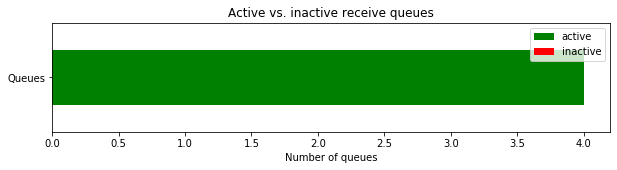

In [8]:
# The function get_apply_status executes a query which counts active vs. inactive queues
# and returns a pandas data frame
df_qstate = get_recvq_state(connection)  

df_qstate.set_index('queues',inplace=True)

# plotting a bar chart
qpl = df_qstate.plot.barh(stacked=True,color=['green', 'red'], 
                          title="Active vs. inactive receive queues",
                          figsize=(10,2))

qpl.set_xlabel("Number of queues")
qpl.set_ylabel("")

[Back to Top](#top)
<a id='qsubs_recvq'></a>

## Subscription STATE by receive queue

Number of active subscriptions (green) vs. number of inactive subscriptions (red) per receive queue

Text(0, 0.5, '')

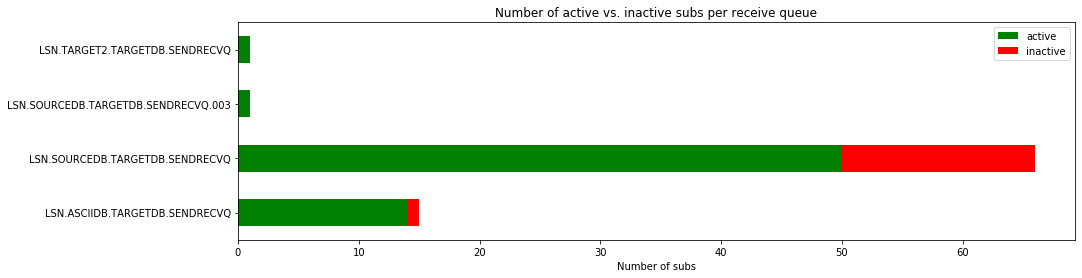

In [9]:
# The function get_substate_by_recvq executes a query which counts active vs. inactive queues
# and returns a pandas data frame
df_q = get_substate_by_recvq(connection)

# Determination of the number of distinct receive queues in the result set
numqs = len(df_q.recvq.unique())

# The hight of the following bar charts depends on the number of distinct receive queues.
# The more queues, the less space per individual queue (to limit the size of the plot)
if numqs >=20:
    calc_fig_height = numqs / 2
if numqs <=2:
    calc_fig_height = numqs * 2
else:
    calc_fig_height =  numqs

df_q.set_index('recvq',inplace=True) 

# plotting a bar chart
sqpl = df_q.plot.barh(stacked=True,color=['green', 'red'],
                       title="Number of active vs. inactive subs per receive queue",
                       figsize=(15,calc_fig_height))

sqpl.set_xlabel("Number of subs")
sqpl.set_ylabel("")

[Back to Top](#top)
<a id='qsubs_type'></a>

## Subscription TYPE Overview

Number of Q Subscription target types per Receive Queue

In [10]:
# The function get_subtype_by_recvq executes a query which counts available subscriptions 
# by type and returns a pandas data frame
df_st = get_subtype_by_recvq(connection)

# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
    print(df_st)

In [11]:
# Determination of the number of distinct receive queues in the result set
numqs = len(df_st.recvq.unique())

# The following plot prints a pie for each queue. Two queues in the same row (fig with 2 columns)
figrows = round(numqs / 2)

print('INFO: Figure will have ' + str(numqs) + ' pie charts in ' + str(figrows) + ' rows and 2 columns')

INFO: Figure will have 4 pie charts in 2 rows and 2 columns


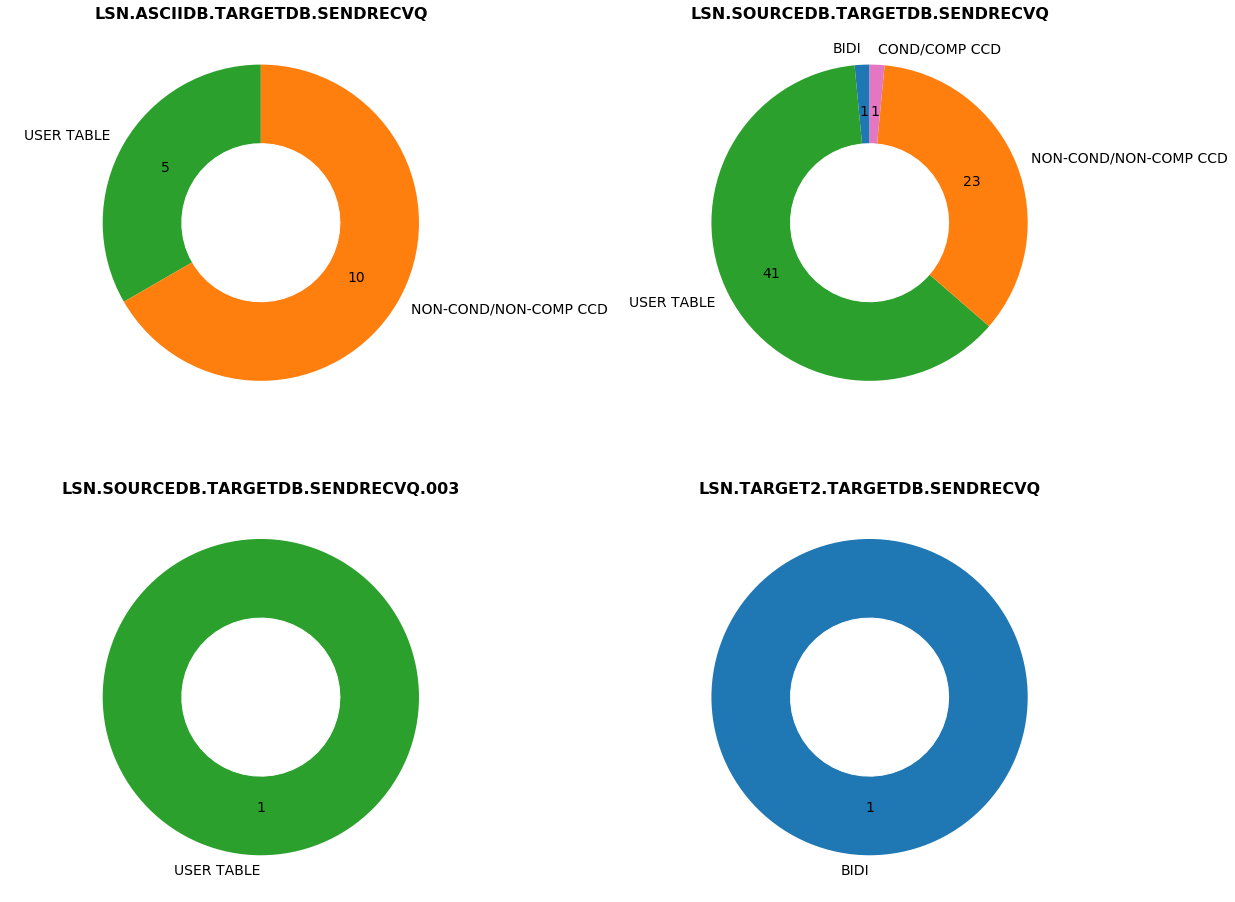

In [12]:
# The function plot_types creates a figure with n donut plots (n = number of queues) to display 
# the different subscription types per queue
subtypeplot = plot_types(df_st,numqs,figrows)
subtypeplot.show()

[Back to Top](#top)
<a id='qapp_performance_hour'></a>

# Q Apply Performance Graphs

## Apply throughput statistics per hour (rows_processed, latency, monsters)

In [13]:
# The function get_perf_applymon executes a query which selects data from IBMQREP_APPLYMON
# and returns a pandas data frame. The APPLYMON data is GROUPed BY hour(monitor_time)
# by the query. In case max_mon_plot_range == -1, the query will retrieve all available data 
# from APPLYMON. If max_mon_plot_range > 0, the APPLYMON data will be limited to the recent
# max_mon_plot_range days

if max_mon_plot_range == -1:              
    print('INFO: Evaluating all available APPLYMON data') 
else:   
    print('INFO: Limiting the APPLYMON data to ' + str(max_mon_plot_range) + ' days.')
              
applymon_lat = get_perf_applymon(connection, max_mon_plot_range)

INFO: Limiting the APPLYMON data to 60 days.


In [14]:
# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
    print(applymon_lat)

In [15]:
# Determine the date of max(monitor_time). This is used when only a subset (e.g., most recent
# 5 days of data) is displayed later. Could be that the Notebook is used to evaluate saved 
# APPLYMON data, so that today() - n days would have no data. 
maxmontime = applymon_lat['monitor_date'].max()
maxmondate = datetime.strptime(maxmontime[:10], "%Y-%m-%d")

if debug:
    print('DEBUG: maxmondate=' + str(maxmondate))
    print()

# Determination of the number of distinct receive queues in the result set
numqs = len(applymon_lat.recvq.unique())

print('INFO: Number of queues=' + str(numqs))

# DEBUG - print the distinct names of the queues
if debug:
   for i in range(0,numqs):
       print('DEBUG: ' + applymon_lat.recvq.unique()[i])

INFO: Number of queues=4


All available data from IBMQREP_APPLYMON (max. <i>max_mon_plot_range</i> days)

INFO: Plotting range: 2019-07-17 - 60 days


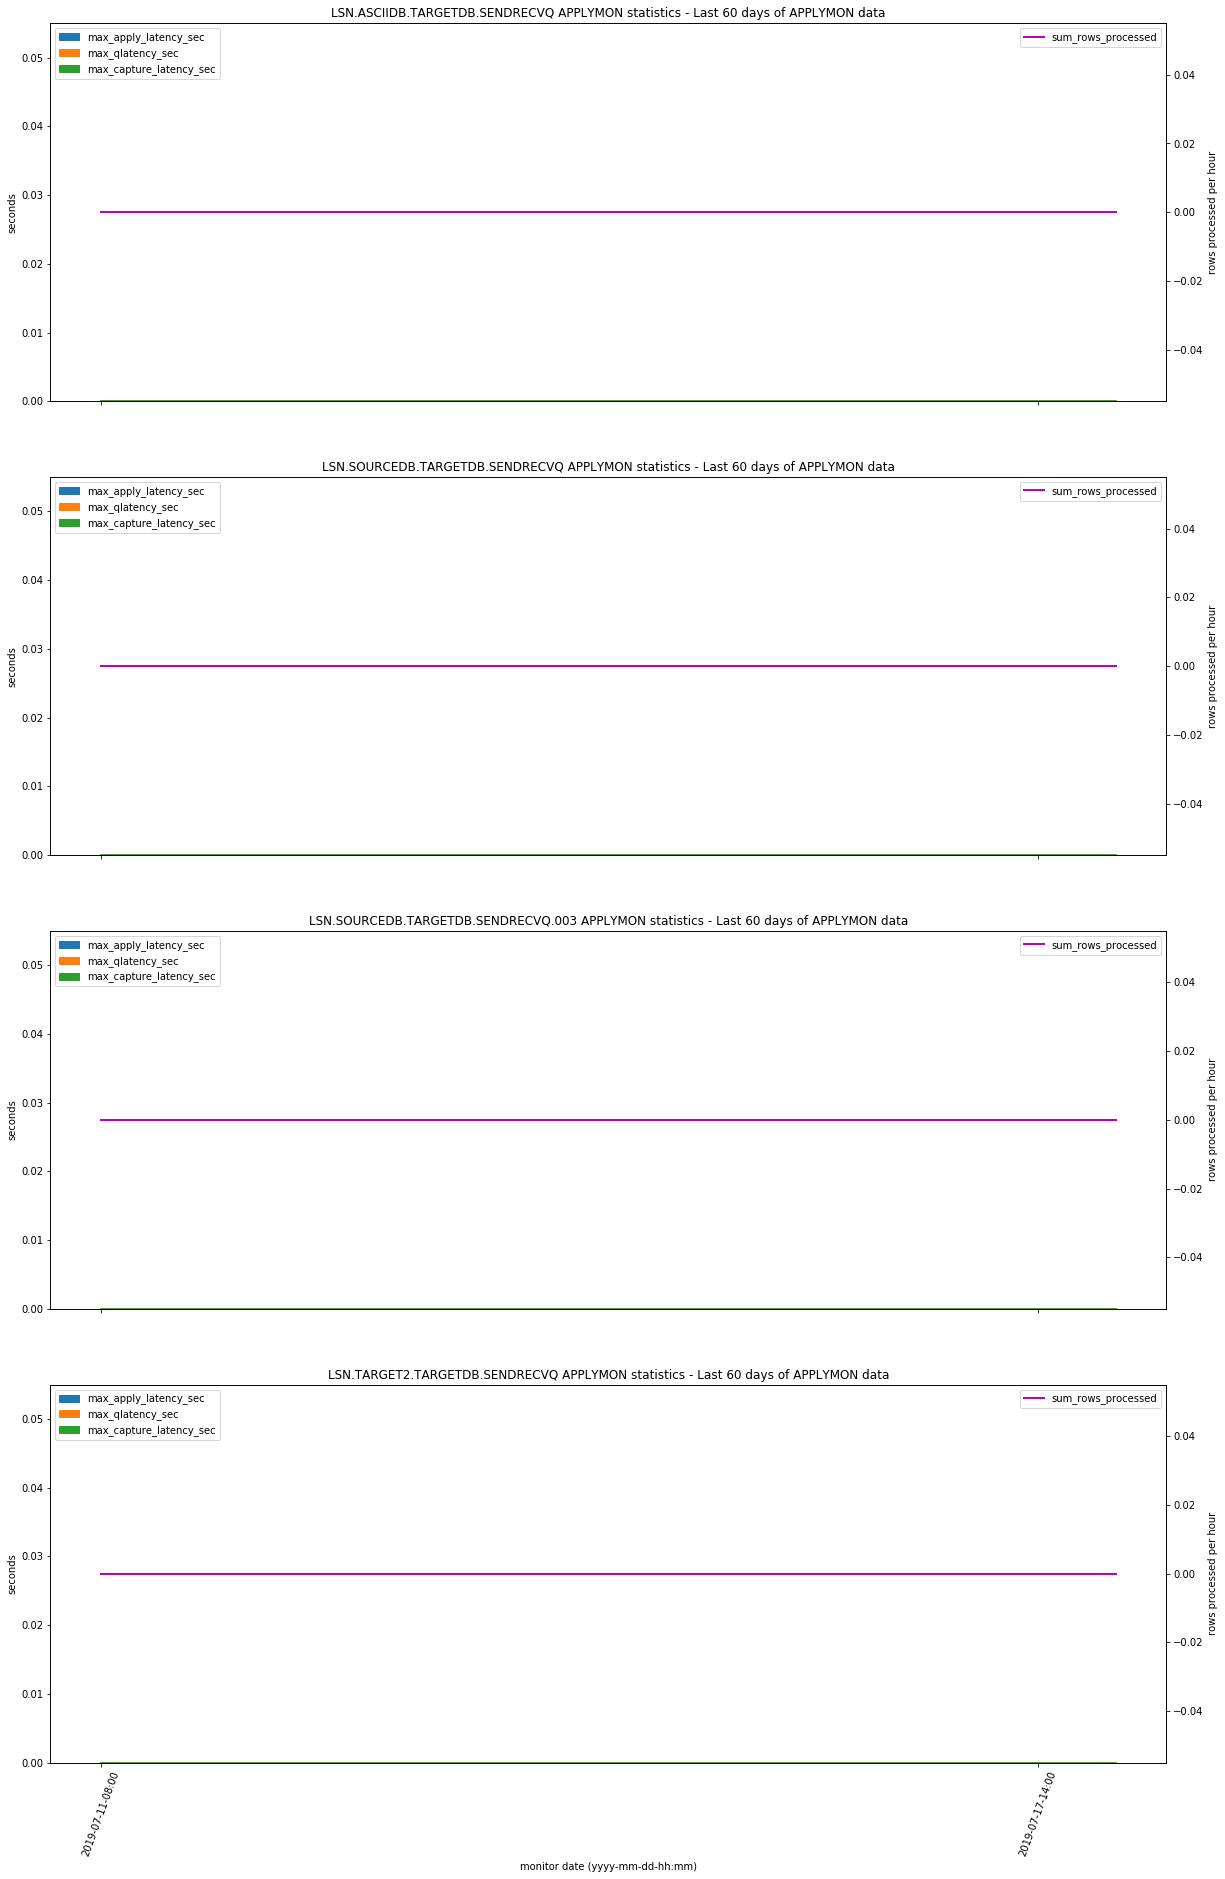

In [16]:
# Plot figure (one plot per queue) with all available data   

# deltadays = -1 means all available data of the data frame
deltadays = max_mon_plot_range

if deltadays == -1:
    print('INFO: Plotting range: All data up to ' + maxmondate.strftime("%Y-%m-%d"))
else:
    print('INFO: Plotting range: ' + maxmondate.strftime("%Y-%m-%d") + ' - ' + str(deltadays) + ' days')

# The function plot_lat creates a figure with n plots (n = number of queues) from the 
# data frame applymon_lat
# The hight of the following figures (calculated in plot_lat) depends on the number of distinct 
# receive queues. The more queues, the less space per individual queue (to limit the size of the figure)
if numqs == 0:
    # Data frame could be empty
    print('WARNING: No data available to display.')
else:    
    applymon_plt60 = plot_lat(applymon_lat,numqs,deltadays,'by_hour')
    applymon_plt60.show()       

Recent 20 days from IBMQREP_APPLYMON

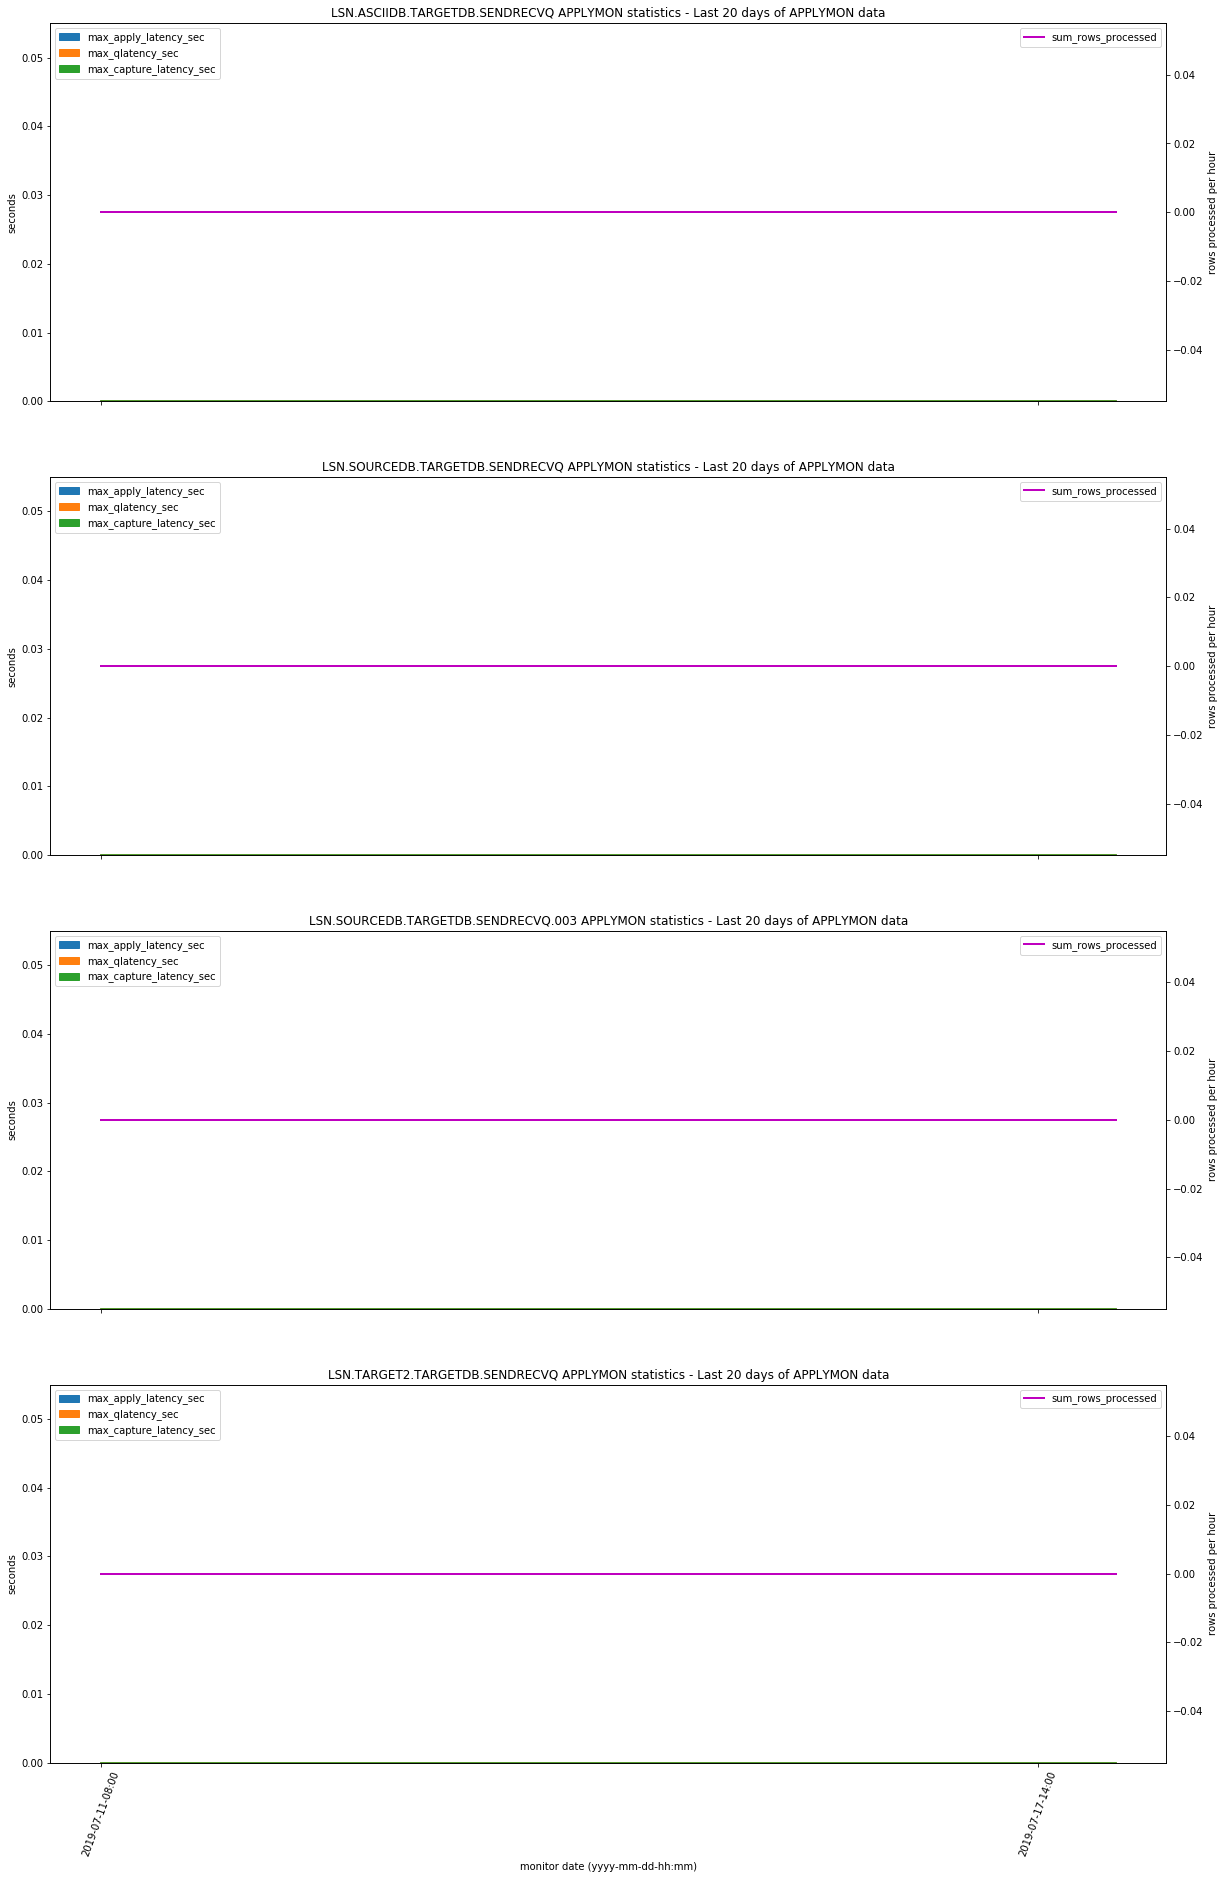

In [17]:
# Zoom in - Same figure as above, with data of the last 20 days only (maxmondate - 20 days)

# display 20 days of data only
deltadays = 20
# old: date_20_days_ago = date.today() - timedelta(days=deltadays)
date_20_days_ago = maxmondate - timedelta(days=deltadays)

# Debug
if debug:
   print('DEBUG: Plotting range: ' + maxmondate.strftime("%Y-%m-%d") + ' - ' + str(deltadays) + ' days')
   print('DEBUG: date_20_days_ago.strftime("%m/%d/%Y"): ' + date_20_days_ago.strftime("%Y-%m-%d"))

# New data frame - limited by the calculated data range
#   - reset_index was introduced to guarantee xticks in the plot
applymon_lat_20 = applymon_lat[applymon_lat.monitor_date 
                               >= date_20_days_ago.strftime("%Y-%m-%d")].reset_index(drop=True)

# The limited data could have a different number of queues
# calc_fig_height remains as calculated before
numqs = len(applymon_lat_20.recvq.unique())

if numqs == 0:
    # Data frame could be empty
    print('WARNING: No data available to display with MONITOR_TIME > ' + date_20_days_ago.strftime("%Y-%m-%d"))
else:
    applymon_plt20 = plot_lat(applymon_lat_20,numqs,deltadays,'by_hour')
    applymon_plt20.show()        

Recent 5 days from IBMQREP_APPLYMON

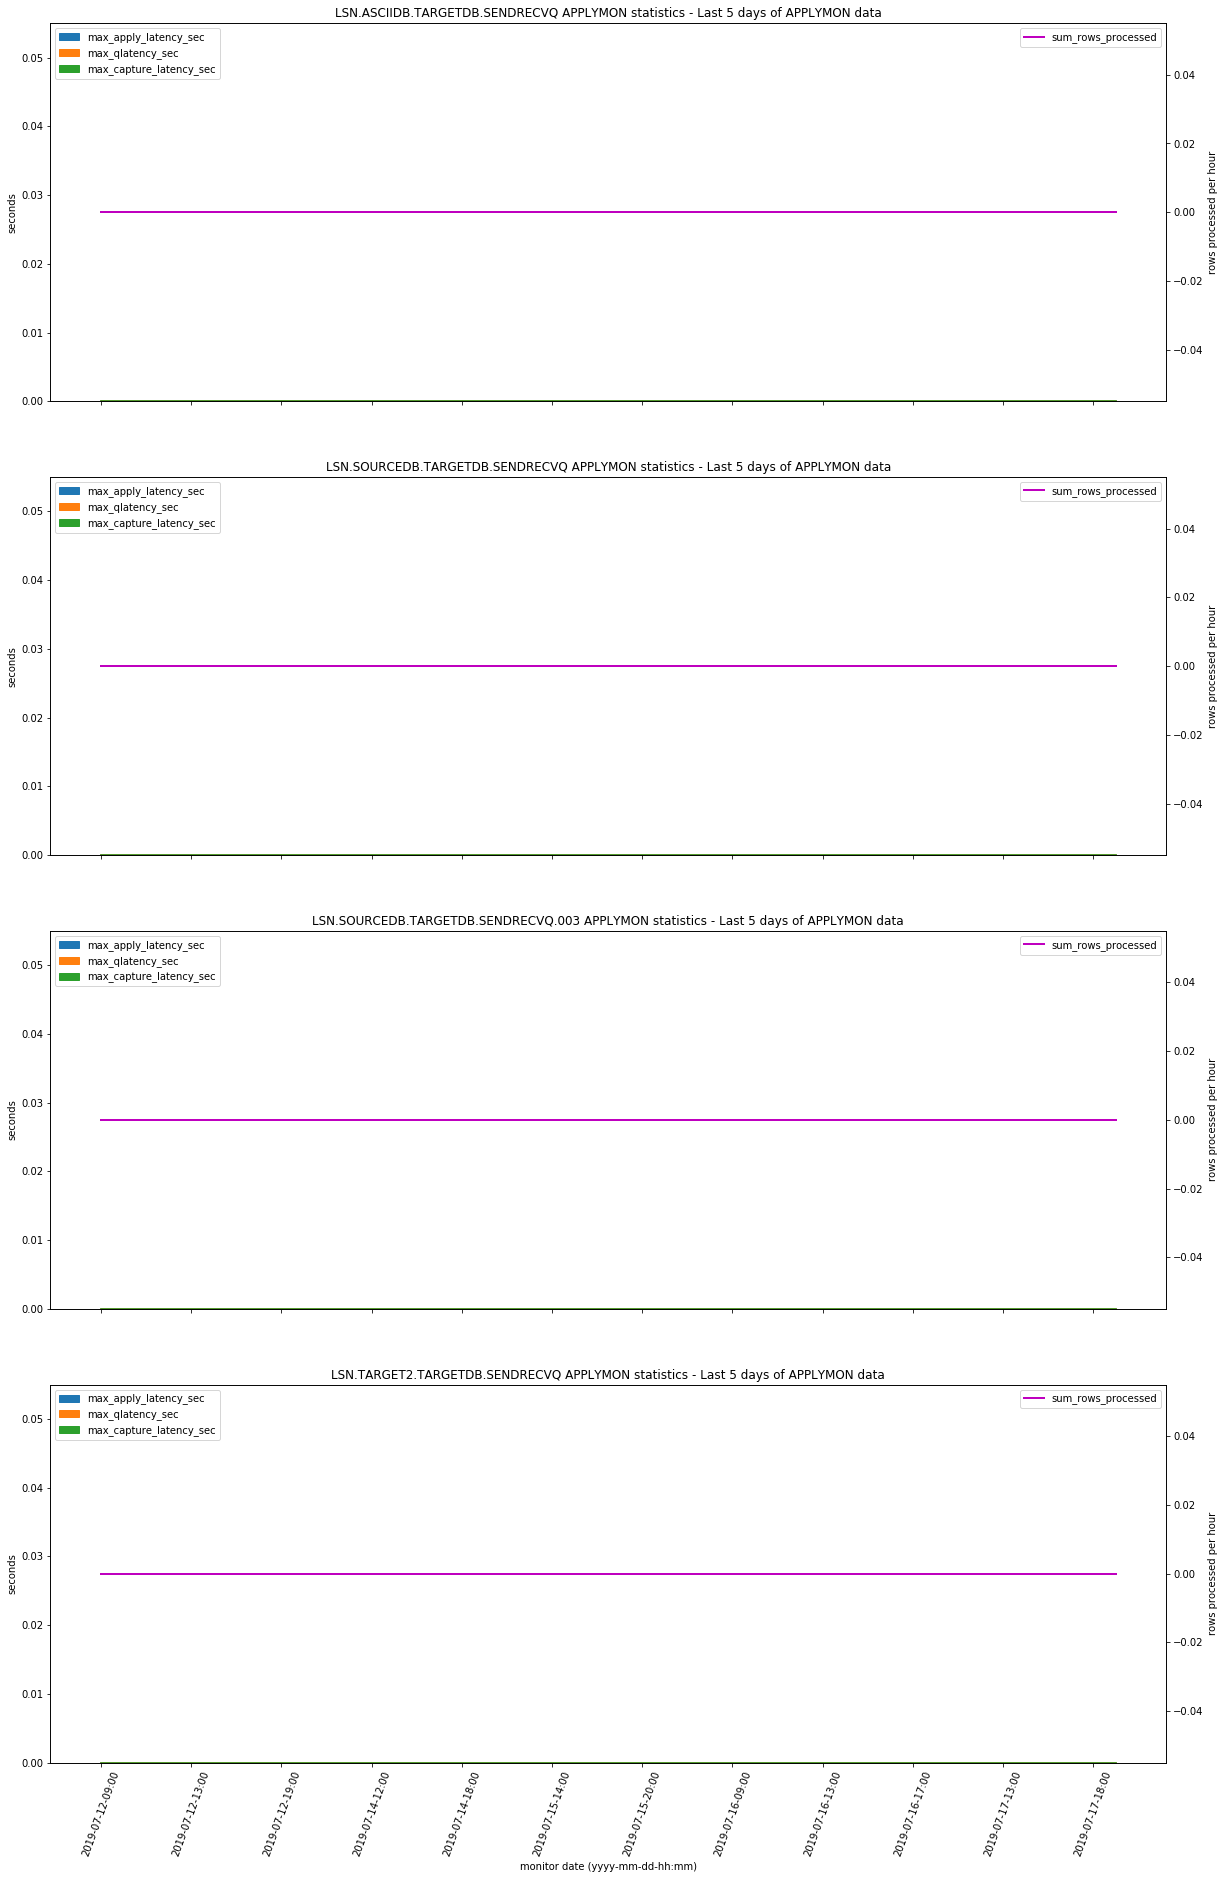

In [18]:
# Zoom in - Same figure as above, with data of the last 5 days only (maxmondate - 5 days)

# display 5 days of data only
deltadays = 5

# old: date_5_days_ago = date.today() - timedelta(days=deltadays)
date_5_days_ago = maxmondate - timedelta(days=deltadays)

# Debug
if debug:
   print('DEBUG: Plotting range: ' + maxmondate.strftime("%Y-%m-%d") + ' - ' + str(deltadays) + ' days')
   print('DEBUG: date_5_days_ago.strftime("%m/%d/%Y"): ' + date_20_days_ago.strftime("%Y-%m-%d"))

# New data frame - limited by the calculated data range 
#   - reset_index was introduced to guarantee xticks in the plot
applymon_lat_5 = applymon_lat[applymon_lat.monitor_date 
                              >= date_5_days_ago.strftime("%Y-%m-%d")].reset_index(drop=True)  

# The limited data could have a different number of queues
# calc_fig_height remains as calculated before
numqs = len(applymon_lat_5.recvq.unique())

if numqs == 0:
    # Data frame could be empty
    print('WARNING: No data available to display with MONITOR_TIME > ' + date_5_days_ago.strftime("%Y-%m-%d"))
else:    
    applymon_plt5 = plot_lat(applymon_lat_5,numqs,deltadays,'by_hour')
    applymon_plt5.show()    

[Back to Top](#top)
<a id='qapp_performance_day'></a>

## Apply throughput statistics per day - all available data from APPLYMON (rows_processed, latency)

In [19]:
# The function get_perf_applymon_day executes a query which selects data from IBMQREP_APPLYMON
# and returns a pandas data frame. The APPLYMON data is GROUPed BY day(monitor_time)
# by the query. The query will retrieve all available data from APPLYMON.

print('INFO: Evaluating all available APPLYMON data') 
              
applymon_lat_day = get_perf_applymon_day(connection)

INFO: Evaluating all available APPLYMON data


In [20]:
# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
   print(applymon_lat_day)

In [21]:
# Determination of the number of distinct receive queues in the result set
numqs = len(applymon_lat_day.recvq.unique())

print('INFO: Number of queues=' + str(numqs))

# DEBUG - print the number of queues and the distinct names of the queues
if debug:
   for i in range(0,numqs):
       print('DEBUG: ' + applymon_lat_day.recvq.unique()[i])

INFO: Number of queues=4


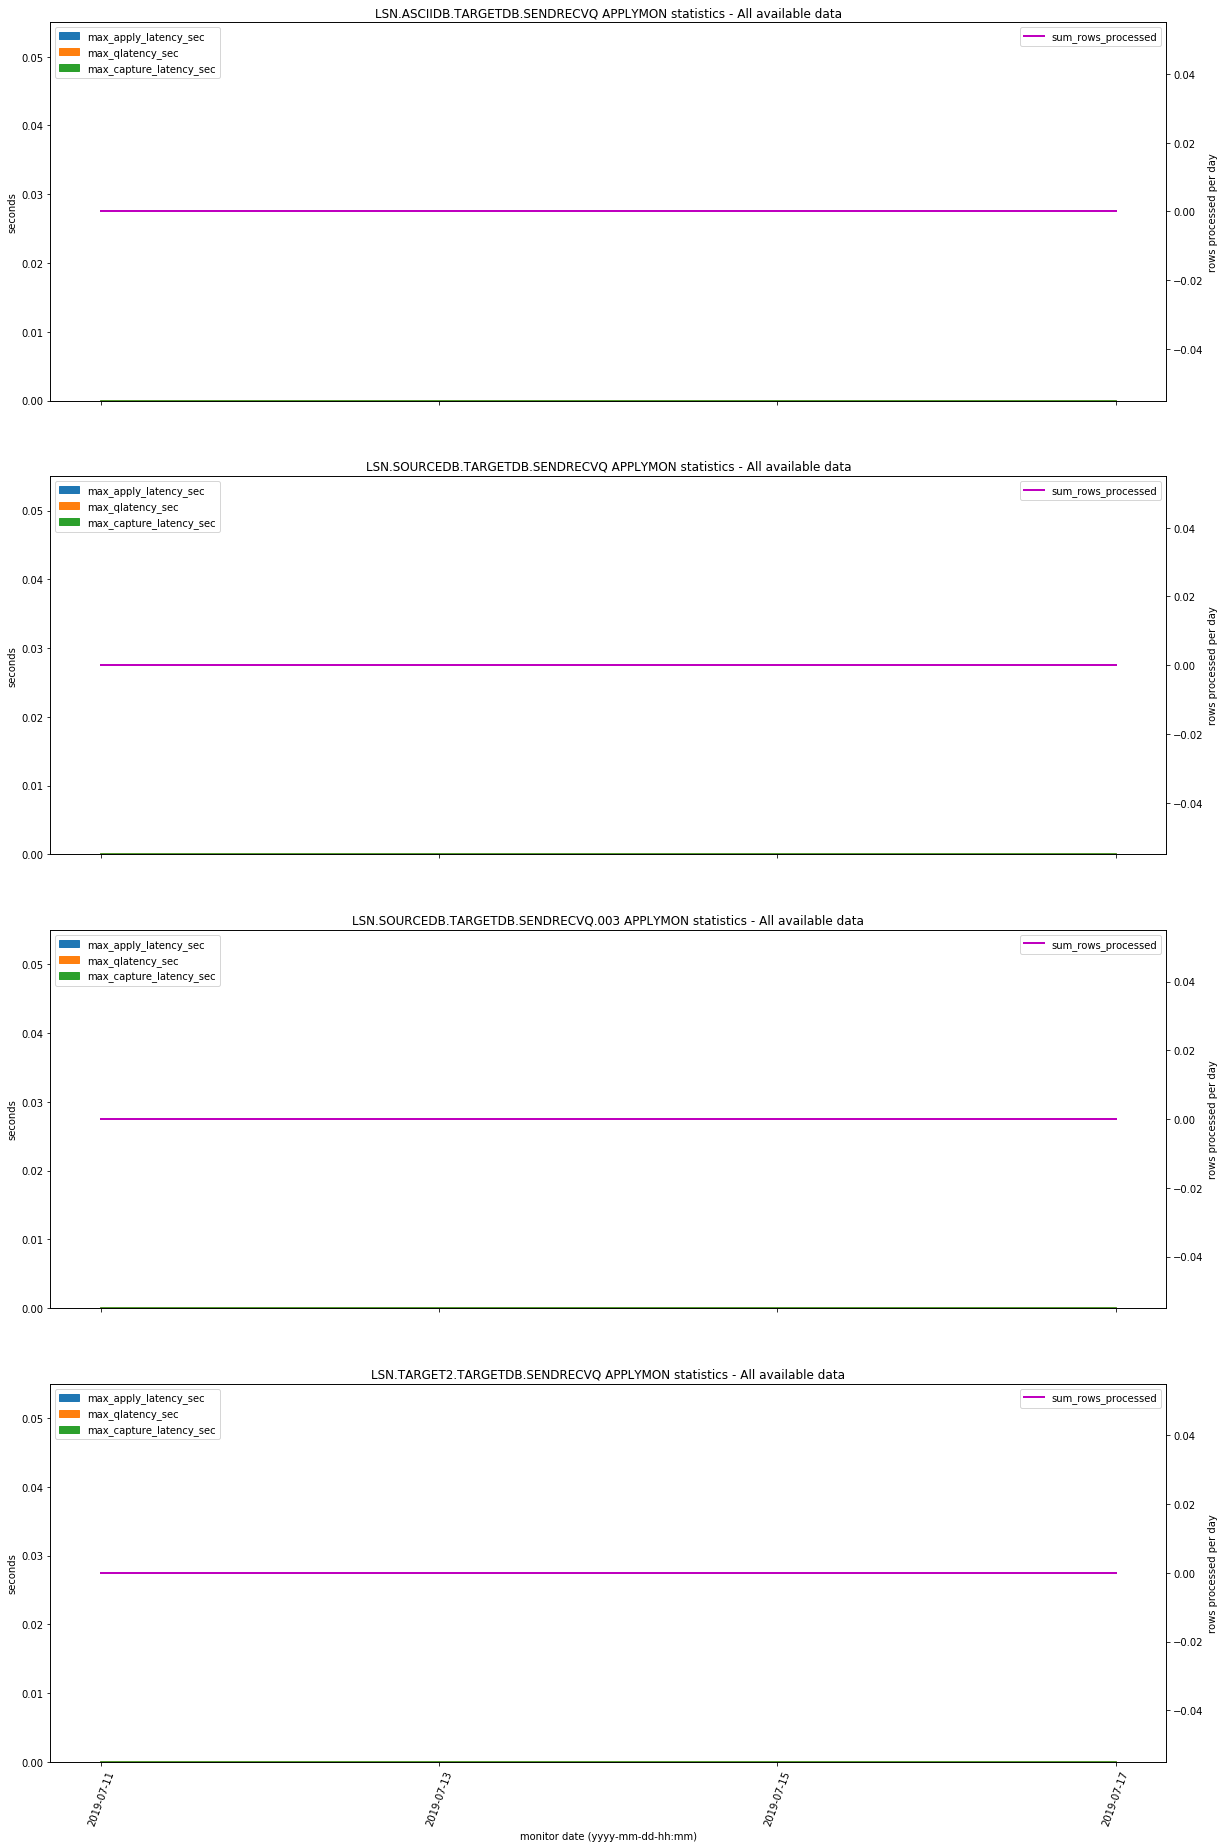

In [22]:
# Plot figure (one plot per queue) with all available data   

deltadays = -1

# The function plot_lat creates a figure with n plots (n = number of queues) from the 
# data frame applymon_lat
# The hight of the following figures (calculated in plot_lat) depends on the number of distinct 
# receive queues. The more queues, the less space per individual queue (to limit the size of the figure)
if numqs == 0:
    # Data frame could be empty
    print('No data available to display')
else:    
    applymon_plt_day = plot_lat(applymon_lat_day,numqs,deltadays,'by_day')
    applymon_plt_day.show() 

[Back to Top](#top)
<a id='qapp_performance_details'></a>

## Detailed Apply throughput statistics (APPLYMON) - one hour of available data

In [23]:
# The function get_perf_applymon_detail executes a query which selects data from IBMQREP_APPLYMON
# and returns a pandas data frame. The query will retrieve one hour of data from APPLYMON, starting 
# at start_ts_mon_plot_details (defined in the defaults section of this Notebook). If 
# start_ts_mon_plot_details == 'max', the last hour of available data will be analyzed

applymon_details = get_perf_applymon_detail(connection, start_ts_mon_plot_details)

In [24]:
# DEBUG - print sample data of the data frame retrieved from APPLYMON
if debug:
   print(applymon_details)

In [25]:
# Determination of the number of distinct receive queues in the result set
numqs = len(applymon_details.recvq.unique())

print('INFO: Number of queues=' + str(numqs))

# DEBUG - print the number of queues and the distinct names of the queues
if debug:
    for i in range(0,numqs):
       print('DEBUG: ' + applymon_details.recvq.unique()[i])

INFO: Number of queues=4


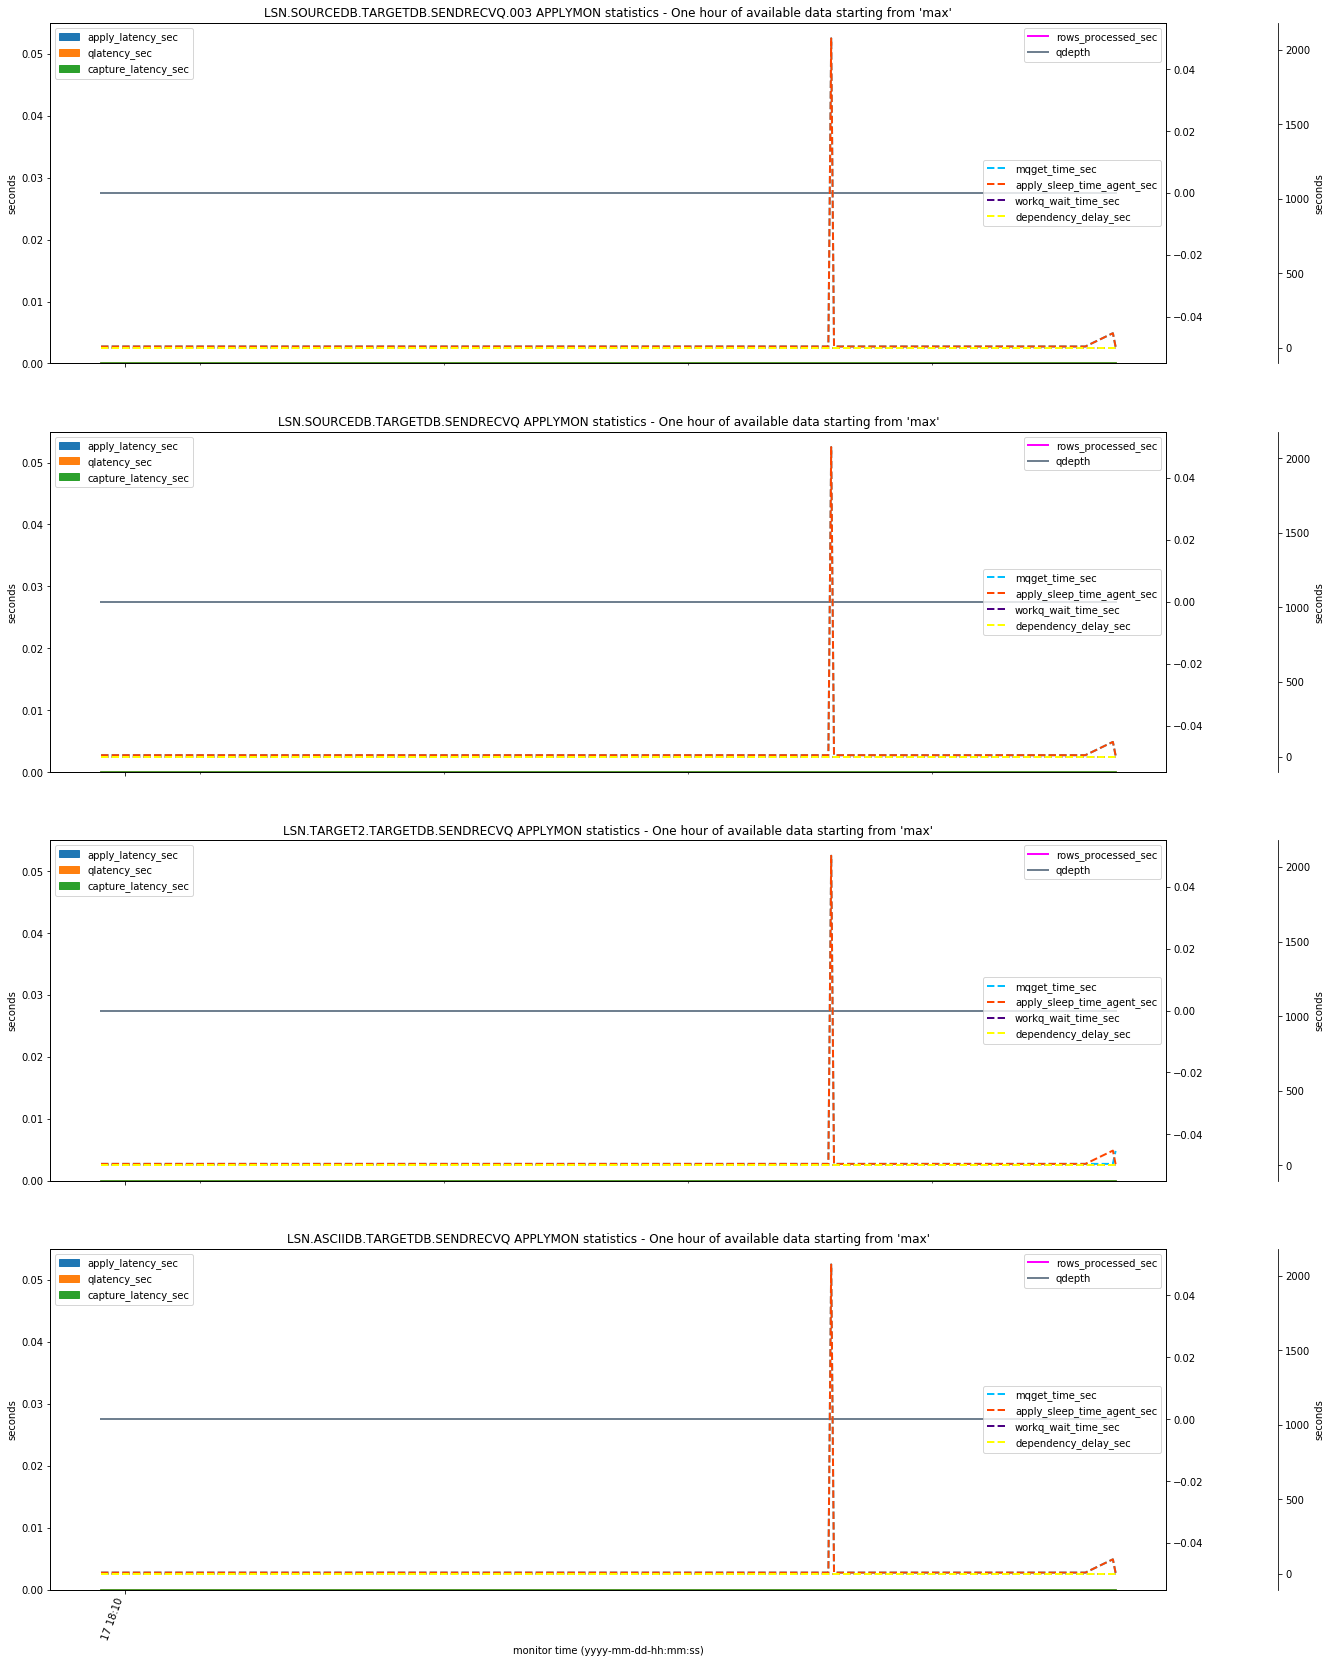

In [26]:
# Plot figure (one plot per queue), 1 hour of data

# The function plot_lat_details creates a figure with n plots (n = number of queues) from the 
# data frame applymon_details
# The hight of the following figures (calculated in plot_lat_details) depends on the number of distinct 
# receive queues. The more queues, the less space per individual queue (to limit the size of the figure)
if numqs == 0:
    # Data frame could be empty
    print('No data available to display with MONITOR_TIME > ' + start_ts_mon_plot_details)
else:    
    applymon_plt_details = plot_lat_details(applymon_details,numqs,start_ts_mon_plot_details,'by_interval')
    applymon_plt_details.show()

[Back to Top](#top)
<a id='qapp_details'></a>

# Q Apply details

## Receive Queue details

Receive queue details (IBMQREP_RECVQUEUES)

In [27]:
# The function get_recvq_details executes a query which selects detail data from IBMQREP_RECVQUEUES
# and returns a pandas data frame
df_queues = get_recvq_details(connection)

df_queues.set_index(['sendq'],inplace=True)
df_queues.sort_values(['sendq'], ascending=[True], inplace=True)

# printing the data frame
df_queues

,recvq,state,repqmapname,adminq,num_apply_agents,memory_limit,capture_server,capture_alias,capture_schema,state_time,...,description,source_type,maxagents_correlid,rollback_r_report,browser_thread_id,parallel_sendqs,mcgname,agent_stmt_cache_sz,mri_memory_limit,bidiapply_schema
sendq,,,,,,,,,,,,,,,,,,,,,
LSN.ASCIIDB.TARGETDB.SENDRECVQ,LSN.ASCIIDB.TARGETDB.SENDRECVQ,A,ASCIIDB_LSN_TO_TARGETDB_LSN,LSN.ASCIIDB.ADMINQ,6,64,ASCIIDB,ASCIIDB,LSN,2019-07-02 16:40:13.485,...,,D,0.0,R,None,N,None,300,1024,None
LSN.SOURCEDB.TARGETDB.SENDRECVQ,LSN.SOURCEDB.TARGETDB.SENDRECVQ,A,SOURCEDB_LSN_TO_TARGETDB_LSN,LSN.SOURCEDB.ADMINQ,6,16,SOURCEDB,SOURCEDB,LSN,2019-07-02 16:40:13.485,...,None,D,NaN,R,None,N,None,300,1024,None
LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,A,XXX,LSN.SOURCEDB.ADMINQ,6,16,SOURCEDB,SOURCEDB,LSN,2019-07-02 16:40:13.485,...,None,D,NaN,R,None,N,None,300,1024,None
LSN.TARGET2.TARGETDB.SENDRECVQ,LSN.TARGET2.TARGETDB.SENDRECVQ,A,TARGET2_LSN_TO_TARGETDB_LSN,LSN.TARGET2.ADMINQ,6,64,TARGET2,TARGET2,LSN,2019-07-02 16:40:13.485,...,,D,0.0,R,None,N,None,300,1024,None


[Back to Top](#top)
<a id='qsubs_details'></a>

## Subscription details

Subscription details (IBMQREP_TARGETS). Use pixiedust options to filter the result set or to convert the table into a  graph.

In [ ]:
# The function get_targets_details executes a query which selects detail data from IBMQREP_TARGETS
# and returns a pandas data frame
df_subs = get_targets_details(connection)

df_subs.sort_values(['subname'], ascending=[True], inplace=True)    

# displaying the data frame using pixiedust
display(df_subs)

subname,state,recvq,sub_id,source_server,source_alias,source_owner,source_name,src_nickname_owner,src_nickname,target_owner,target_name,target_type,federated_tgt_srvr,state_time,state_info,subtype,conflict_rule,conflict_action,error_action,spillq,oksqlstates,subgroup,source_node,target_node,group_init_role,has_loadphase,load_type,description,search_condition,modelq,ccd_condensed,ccd_complete,source_type,schema_subname,sub_creator,repl_drop_col,repl_rename_col,repl_alter_col,src_location_alias,codepage_expand_factor,ccd_keyupd_as_delins
ACCOUNT_BITEMP_SOURCE_STT_2_NSTT,A,LSN.SOURCEDB.TARGETDB.SENDRECVQ,86.0,SOURCEDB,SOURCEDB,BANK,ACCOUNT_BITEMP_SOURCE,None,None,BANK,ACCOUNT_BITEMP_TARGET,1,None,2018-09-11 16:56:09.563000,ASN7606I,U,K,I,D,IBMQREP.SPILL.MODELQ.2.86.2,None,None,0,0,None,I,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N
ACCOUNT_BITEMP_SOURCE_STT_2_STT,A,LSN.SOURCEDB.TARGETDB.SENDRECVQ,87.0,SOURCEDB,SOURCEDB,BANK,ACCOUNT_BITEMP_SOURCE,None,None,BANK,ACCOUNT_BITEMP_SOURCE,1,None,2018-09-11 17:13:30.449000,ASN7606I,U,K,I,D,IBMQREP.SPILL.MODELQ.2.87.1,None,None,0,0,None,I,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N
ACCOUNT_BITEMP_SOURCE_STT_2_STT_HIST,A,LSN.SOURCEDB.TARGETDB.SENDRECVQ,88.0,SOURCEDB,SOURCEDB,BANK,ACCOUNT_BITEMP_SOURCE_HIST,None,None,BANK,ACCOUNT_BITEMP_SOURCE_HIST,1,None,2018-09-11 17:14:34.043000,ASN7606I,U,K,I,D,IBMQREP.SPILL.MODELQ.2.88.1,None,None,0,0,None,I,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N
ALTER_CHAR_VARCHAR,A,LSN.SOURCEDB.TARGETDB.SENDRECVQ,50.0,SOURCEDB,SOURCEDB,DE094692,ALTER_CHAR_VARCHAR,None,None,DE094692,ALTER_CHAR_VARCHAR,2,None,2017-08-21 17:59:53.165000,ASN7606I,U,K,F,D,None,None,None,0,0,None,N,0,None,None,IBMQREP.SPILL.MODELQ,N,N,D,None,asnclp,Y,Y,Y,None,1,N
ASN7099E_1,A,LSN.SOURCEDB.TARGETDB.SENDRECVQ,67.0,SOURCEDB,SOURCEDB,DE094692,ASN7099E_1,None,None,DE094692,ASN7099E_1,1,None,2017-10-17 13:34:06.781000,ASN7606I,U,K,I,D,None,None,None,0,0,None,I,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N
ASN7099E_2,A,LSN.SOURCEDB.TARGETDB.SENDRECVQ,68.0,SOURCEDB,SOURCEDB,DE094692,ASN7099E_2,None,None,DE094692,ASN7099E_2,1,None,2017-10-17 13:41:43.111000,ASN7606I,U,K,I,D,None,None,None,0,0,None,I,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N
BLOBTEST_SOURCE0001,I,LSN.SOURCEDB.TARGETDB.SENDRECVQ,nan,SOURCEDB,SOURCEDB,DE094692,BLOBTEST_SOURCE,None,None,DE094692,BLOBTEST_TARGET,1,None,2016-09-12 13:40:59.109000,None,U,K,I,Q,None,None,None,0,0,None,I,0,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,None,Y,Y,Y,None,1,N
B_KONTO_TEST_0001,I,LSN.SOURCEDB.TARGETDB.SENDRECVQ,7.0,SOURCEDB,SOURCEDB,BANK,KONTO,None,None,BANK,B_KONTO_TEST,1,None,2016-12-14 13:56:50.693000,ASN7700I,U,K,I,D,None,None,None,0,0,None,N,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N
CHILD1,A,LSN.SOURCEDB.TARGETDB.SENDRECVQ,59.0,SOURCEDB,SOURCEDB,DE094692,CHILD1,None,None,DE094692,CHILD1,1,None,2017-09-22 11:35:07.697000,ASN7606I,U,K,I,D,IBMQREP.SPILL.MODELQ.2.59.1,None,None,0,0,None,I,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N
CHILD2,A,LSN.SOURCEDB.TARGETDB.SENDRECVQ,60.0,SOURCEDB,SOURCEDB,DE094692,CHILD2,None,None,DE094692,CHILD2,1,None,2017-09-22 11:35:07.749000,ASN7606I,U,K,I,D,IBMQREP.SPILL.MODELQ.2.60.1,None,None,0,0,None,I,1,None,None,IBMQREP.SPILL.MODELQ,Y,Y,D,None,asnclp,Y,Y,Y,None,1,N


[Back to Top](#top)
<a id='qsubs_qa'></a>

## Subscription quality assurance

Runtime error prevention for existing subscriptions. The following potential error situations are reported:
 <ul>
  <li>A-TNF - Target table not found</li>
  <li>A-CNF - Subscribed column does not exist in DB2</li>
  <li>A-CNS - Existing target column not subscribed</li>
  <li>A-GRA - Target table grant missing for Apply user</li>
  <li>A-RIP - Sub for RI parent of a replicated RI child missing</li>
  <li>A-RIC - Sub for RI child of a replicated RI parent missing</li>
  <li>A-BID - Before image column has different data type than after image column</li>
</ul> 

In [29]:
# The function get_apply_anomylies executes the query 'qrep_check_subs_apply.sql' 
# (with language dependent result set) and returns a pandas data frame
df_appqa = get_apply_anomylies(connection)

df_appqa.drop(df_appqa.columns[2], axis=1, inplace=True)

# conditional formatting for column 'sev'
df_appqa = (df_appqa.style
    .applymap(sev_background, subset=['sev'])
    .applymap(sev_foreground, subset=['sev'])
)

# printing the data frame
df_appqa

,check_ts,PROGRAM,mtyp,sev,mtxt,fixit,target_owner
0,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-TNF,WARNING,"QSUB KONTO_0001 (I) for target table BANK.KONTO, STATE=I, exists, but the table does not exist in DB2! Remove the subscription.","DROP QSUB ( SUBNAME ""KONTO_0001"" USING REPLQMAP SOURCEDB_LSN_TO_TARGETDB_LSN);",BANK
1,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (A) contains target column DE094692.ASN7099E_2.NEWCOL_21 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_21,DE094692
2,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (A) contains target column DE094692.ASN7099E_2.NEWCOL_22 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_22,DE094692
3,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (A) contains target column DE094692.ASN7099E_2.NEWCOL_23 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_23,DE094692
4,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (A) contains target column DE094692.ASN7099E_2.NEWCOL_24 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_24,DE094692
5,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-CNF,ERROR,QSUB ASN7099E_2 (A) contains target column DE094692.ASN7099E_2.NEWCOL_25 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.ASN7099E_2 ADD COLUMN NEWCOL_25,DE094692
6,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains target column DE094692.CODEPAGE_EXPAND_FACTOR_CCD.NEWCOL_2_VARCHAR_400 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR_CCD ADD COLUMN NEWCOL_2_VARCHAR_400,DE094692
7,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains target column DE094692.CODEPAGE_EXPAND_FACTOR_CCD.NEWCOL_CHAR but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR_CCD ADD COLUMN NEWCOL_CHAR,DE094692
8,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains target column DE094692.CODEPAGE_EXPAND_FACTOR_CCD.NEWCOL_CHAR_10 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR_CCD ADD COLUMN NEWCOL_CHAR_10,DE094692
9,2019-07-24 17:05:21.012000,ASNQAPP(LSN),A-CNF,ERROR,QSUB CODEPAGE_EXPAND_FACTOR_CCD (A) contains target column DE094692.CODEPAGE_EXPAND_FACTOR_CCD.NEWCOL_CHAR_200 but the column does not exist in DB2! Modify the subscription.,ALTER TABLE DE094692.CODEPAGE_EXPAND_FACTOR_CCD ADD COLUMN NEWCOL_CHAR_200,DE094692


[Back to Top](#top)
<a id='qapp_cntl'></a>

# Q Apply Control Tables

## Q Apply parameters

Stored Q Apply parameters (IBMQREP_APPLYPARMS)

In [30]:
# The function get_applyparms executes a query which selects detail data from IBMQREP_APPLYPARMS
# and returns a pandas data frame
df_applyparms = get_applyparms(connection)

# printing the data frame
df_applyparms

,qmgr,monitor_limit,trace_limit,monitor_interval,prune_interval,autostop,logreuse,logstdout,apply_path,arch_level,...,use_applycmd_table,applycmd_interval,warntxlatency,warntxevts,warntxreset,commit_count_unit,possible_level,current_level,control_tables_level,skip_spilledrow_table
0,LSN,10080,10080,10000,300,N,N,Y,C:\asnrun,1140,...,Y,3000,0,10,300000,T,1140.101,1140.101,1140.101,Y


[Back to Top](#top)
<a id='qapp_mon'></a>

## Q Apply APPLYMON

In [31]:
# Calculate the monitoring date range
# - as lowest date:
#      - in case custom_mon_start_date == -1 take current date - daterange days, otherweise custom_mon_start_date
# - as highest date:
#      - in case custom_mon_end_date == -1 take current date, otherweise custom_mon_start_date

# The function calc_mon_start_end calculates the interval to retrieve from APPLYMON from 
# custom_mon_start_date, custom_mon_end_date, default_mon_date_range. It returns an array with 2 timestamps
calc_mon_dates = calc_mon_start_end(custom_mon_start_date, custom_mon_end_date, default_mon_date_range)

mon_start_date = calc_mon_dates[0]
mon_end_date = calc_mon_dates[1]

# Debug
if debug:
    print("Monitor Start Date: " + mon_start_date)
    print("Monitor End Date:   " + mon_end_date)

In [ ]:
# The function get_applymon executes a query which selects detail data from IBMQREP_APPLYMON
# and returns a pandas data frame
df_applymon = get_applymon(connection, mon_start_date, mon_end_date)

df_applymon.set_index('monitor_time')

# sort does not seem to work
df_applymon.sort_values(['monitor_time'], ascending=False, inplace=True)

# displaying the data frame using Pixiedust
display(df_applymon)

monitor_time,recvq,qstart_time,current_memory,qdepth,end2end_latency,qlatency,apply_latency,trans_applied,rows_applied,trans_serialized,ri_dependencies,ri_retries,deadlock_retries,rows_not_applied,monster_trans,mem_full_time,apply_sleep_time,spilled_rows,spilledrowsapplied,oldest_trans,oksqlstate_errors,heartbeat_latency,key_dependencies,uniq_dependencies,uniq_retries,oldest_inflt_trans,job_dependencies,capture_latency,oldest_commit_lsn,rows_processed,q_percent_full,oldest_commit_seq,mq_bytes,mqget_time,num_mqgets,trans_read,dependency_delay,mcgsync_delay,workq_wait_time,retry_time,dbms_time,stmts_prepared,num_mri_stmts_executed,rows_processed_mri,current_memory_stmt_cache,unavail_res_retries,num_mqmsgs,oldest_commit_time,num_dbms_commits
2019-07-15 19:57:53.760000,LSN.ASCIIDB.TARGETDB.SENDRECVQ,2019-07-02 16:40:13.893000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60023,0,0,2019-07-05 10:34:39,0,0,0,0,0,None,0,0,00000000002209B000000000019C1334,0,0,5D1F0B9F000000000000000000000000,0,10004,5,0,0,0,0,0,0,0,0,0,2157,0,0,2019-07-02 16:36:01.000011,0
2019-07-15 20:39:54.301000,LSN.ASCIIDB.TARGETDB.SENDRECVQ,2019-07-02 16:40:13.893000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60008,0,0,2019-07-05 10:34:39,0,0,0,0,0,None,0,0,00000000002209B000000000019C1334,0,0,5D1F0B9F000000000000000000000000,0,10002,5,0,0,0,0,0,0,0,0,0,2157,0,0,2019-07-02 16:36:01.000011,0
2019-07-14 17:09:02.995000,LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,2019-07-02 16:40:13.620000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60017,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,0,10004,5,0,0,0,0,0,0,0,0,0,0,0,0,NaT,0
2019-07-17 14:19:54.351000,LSN.ASCIIDB.TARGETDB.SENDRECVQ,2019-07-02 16:40:13.893000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60024,0,0,2019-07-05 10:34:39,0,0,0,0,0,None,0,0,00000000002209B000000000019C1334,0,0,5D1F0B9F000000000000000000000000,0,10004,5,0,0,0,0,0,0,0,0,0,2157,0,0,2019-07-02 16:36:01.000011,0
2019-07-16 13:59:37.745000,LSN.SOURCEDB.TARGETDB.SENDRECVQ,2019-07-02 16:40:14.368000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60012,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,0,10002,5,0,0,0,0,0,0,0,0,0,0,0,0,NaT,0
2019-07-16 11:42:22.434000,LSN.TARGET2.TARGETDB.SENDRECVQ,2019-07-02 16:40:13.741000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60012,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,0,10002,5,0,0,0,0,0,0,0,0,0,0,0,0,NaT,0
2019-07-16 11:16:42.131000,LSN.SOURCEDB.TARGETDB.SENDRECVQ.003,2019-07-02 16:40:13.620000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60015,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,0,10003,5,0,0,0,0,0,0,0,0,0,0,0,0,NaT,0
2019-07-16 09:50:11.152000,LSN.ASCIIDB.TARGETDB.SENDRECVQ,2019-07-02 16:40:13.893000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60021,0,0,2019-07-05 10:34:39,0,0,0,0,0,None,0,0,00000000002209B000000000019C1334,0,0,5D1F0B9F000000000000000000000000,0,10004,5,0,0,0,0,0,0,0,0,0,2157,0,0,2019-07-02 16:36:01.000011,0
2019-07-15 21:18:38.459000,LSN.TARGET2.TARGETDB.SENDRECVQ,2019-07-02 16:40:13.741000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60017,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,0,10003,5,0,0,0,0,0,0,0,0,0,0,0,0,NaT,0
2019-07-16 17:19:31.675000,LSN.TARGET2.TARGETDB.SENDRECVQ,2019-07-02 16:40:13.741000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4330033,0,0,1900-01-01 00:00:00,0,0,0,0,0,None,0,0,00000000000000000000000000000000,0,0,00000000000000000000000000000000,0,4300057,4,0,0,0,0,0,0,0,0,0,0,0,0,NaT,0


[Back to Top](#top)
<a id='qapp_trace'></a>

## Q Apply message log

Displaying the n (num_messages_trace) most recent runtime log messages from IBMQREP_APPLYTRACE 

In [ ]:
# The function get_applytrace executes a query which selects detail data from IBMQREP_APPLYTRACE
# and returns a pandas data frame
df_applytrace = get_applytrace(connection, num_messages_trace)

# sort does not seem to work
df_applytrace.sort_values(['trace_time'], ascending=False, inplace=True)

# displaying the data frame using Pixiedust
display(df_applytrace)

operation,trace_time,description,reason_code,mq_code


[Back to Top](#top)
<a id='end'></a>

Done.

## Release Notes

<b>08.05.2019:</b> This is the initial release of the Jupyter Notebook for Q Apply monitoring. It is the beginning of a learning curve and uses various Python and Jupyter Notebook techniques such as:
 <ul>    
   <li>Db2 Python libraries</li>
   <li>Pandas data frames</li>
   <li>Pixiedust for result set visualization</li>
   <li>matplotlib for the graphical representation of performance statistics</li>
 </ul>    
<b>17.06.2019:</b> Added another plot: one hour of detailed APPLYMON data. By default, the most recent hour of available APPLYMON data is displayed. If you want to display a certain hour, change the variable <i>start_ts_mon_plot_details</i> in the customization section at the top of the Notebook.<p>
<b>12.07.2019:</b> Fixed not displayed xticks for plots with limited date ranges (20 days, 5 days) by resetting the index after filtering the data frame (<i>.reset_index(drop=True)</i>)<p>
<b>23.07.2019:</b> Added another plot: Donut charts per receive queue to visualize the different subsciption types
per queue.

## Feedback

Feedback and ideas for improvement are welcome and can be sent to clenke@de.ibm.com